In [1]:
from datasets import load_dataset
import pandas as pd

In [2]:
emotions = load_dataset("emotion")

In [10]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [12]:
train_ds = emotions['train']

In [13]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [14]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [16]:
emotions.set_format(type="pandas")

In [17]:
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [18]:
df['label_name'] = df['label'].apply(lambda x: emotions["train"].features["label"].int2str(x))

In [19]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [20]:
import matplotlib.pyplot as plt

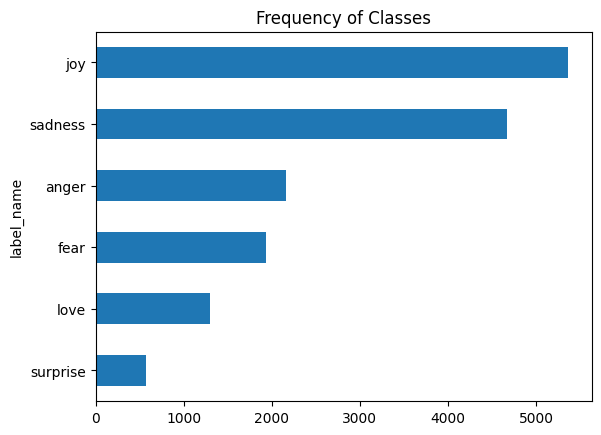

In [21]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

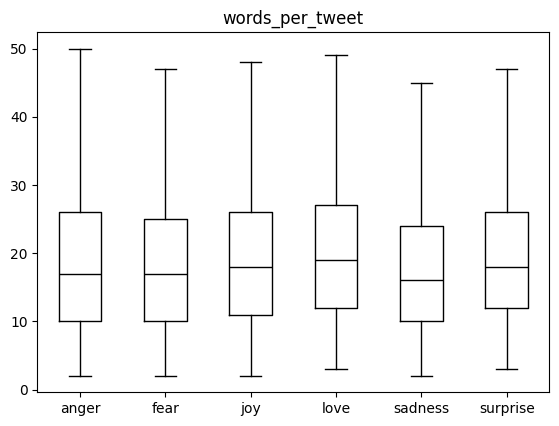

In [25]:
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.boxplot("words_per_tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [26]:
emotions.reset_format()

## Tokenisation

In [3]:
from transformers import AutoTokenizer

In [4]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [29]:
text = "Tokenizing text is a core task of NLP."

In [30]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [31]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [32]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [33]:
tokenizer.vocab_size

30522

In [34]:
tokenizer.model_max_length

512

In [35]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [5]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [37]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


## Text classification using feature feature extractor

In [6]:
import torch
from transformers import AutoModel
import numpy as np

In [5]:
text = "Tokenizing text is a core task of NLP."
inputs = tokenizer(text,return_tensors="pt")

In [33]:
tokenizer.encode(text)

[101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102]

In [6]:
inputs

{'input_ids': tensor([[  101, 19204,  6026,  3793,  2003,  1037,  4563,  4708,  1997, 17953,
          2361,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [18]:
inputs['input_ids'].size()

torch.Size([1, 13])

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
inputs = {k:v.to(device) for k,v in inputs.items()}

In [8]:
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [15]:
model.eval()
with torch.inference_mode():
    outputs = model(**inputs)

In [16]:
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.5274, -0.2094, -0.3702,  ..., -0.2226, -0.2209,  0.6306],
         [-0.8933,  0.1909, -0.5291,  ..., -0.3937, -0.1585,  0.3817],
         [-0.5556,  0.1427, -0.5014,  ..., -0.3935, -0.3470,  0.6484],
         ...,
         [-0.4909, -0.3005, -0.0368,  ..., -0.0892, -0.6761,  0.3377],
         [ 0.5523, -0.0374, -0.6801,  ...,  0.2615, -0.7397, -0.2420],
         [ 0.4775,  0.1837, -0.4203,  ...,  0.2080, -0.9114, -0.0827]]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [17]:
outputs.last_hidden_state.size()

torch.Size([1, 13, 768])

In [20]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze())

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

In [9]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [24]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [10]:
emotions_encoded.set_format("torch", columns=["input_ids","attention_mask", "label"])

In [62]:
def extract_hidden_state(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.inference_mode():
        outputs = model(**inputs)
    return {'hidden_state': outputs.last_hidden_state[:, 0].cpu().numpy()}

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_state, batched=True)

In [31]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [35]:
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

In [36]:
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

## Fine tuning

In [11]:
from transformers import AutoModelForSequenceClassification

In [12]:
num_labels = len(emotions['train'].features['label'].names)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from sklearn.metrics import accuracy_score, f1_score

In [25]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1":f1}

In [15]:
import os
from huggingface_hub import notebook_login

In [16]:
os.environ['HF_HOME'] = "/hps/nobackup/pdbe/users/roshan/llm"

In [23]:
notebook_login()

In [18]:
from transformers import Trainer, TrainingArguments

In [20]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01, 
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [26]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics, train_dataset=emotions_encoded["train"], eval_dataset=emotions_encoded["validation"], processing_class=tokenizer)
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.203600,0.166168,0.934000,0.933955
2,0.132900,0.148002,0.938500,0.938733


TrainOutput(global_step=500, training_loss=0.1682748031616211, metrics={'train_runtime': 57.697, 'train_samples_per_second': 554.622, 'train_steps_per_second': 8.666, 'total_flos': 720342861696000.0, 'train_loss': 0.1682748031616211, 'epoch': 2.0})